In [1]:
import sys
import pandas as pd
import ast
import pickle
from torch.utils.data import DataLoader
import anndata as ad
import scanpy as sc
import numpy as np
import networkx as nx
from dotenv import find_dotenv, load_dotenv

load_dotenv(find_dotenv())

sys.path.append('../src/null-effect-net')
import utils
import models
import dataset

In [2]:
G = nx.read_edgelist('../data/networks/global_ppi_edgelist.txt')

G

In [3]:
G.nodes

NodeView(('FLNC', 'MAP2K4', 'SGCD', 'SGCG', 'MYOZ1', 'KCND2', 'PHLDB2', 'INPPL1', 'TRIM54', 'FBXL22', 'XIRP1', 'SYNPO2', 'FBXW11', 'SIAH2', 'AGR2', 'ANK3', 'UBE2I', 'TRIM63', 'PIK3R1', 'ADRA1A', 'GRB2', 'HIPK3', 'ABL1', 'MLH1', 'WNK1', 'PCBP2', 'AKT1', 'PLCG1', 'NCK1', 'FYN', 'CAMKK2', 'MYOZ3', 'CRK', 'SMURF2', 'WIPI2', 'AKT2', 'OTUD1', 'OTUD4', 'USP53', 'CAPN3', 'ADRA1B', 'MYOZ2', 'ADRA1D', 'TNFAIP8', 'FURIN', 'NPHP1', 'RASSF5', 'KY', 'MYOT', 'MAPK8', 'MAPK8IP3', 'MAP3K4', 'ARRB2', 'MAP3K2', 'MAP3K1', 'ITCH', 'MAPK9', 'BLNK', 'MAPK10', 'MAP3K5', 'MAPK14', 'MAP3K3', 'MAP3K7', 'GEMIN5', 'NBR1', 'RXRA', 'MAP3K14', 'MAPK1', 'RBM17', 'CFLAR', 'MAP3K10', 'MAP3K8', 'MAPK3', 'MAP3K12', 'NEFL', 'EFNA4', 'MAP4K2', 'CANX', 'MAPK12', 'MAP3K11', 'DUSP22', 'MAP2K1', 'NPHS1', 'ARRB1', 'TRIB1', 'APBB1', 'AKT3', 'MAP2K7', 'ALK', 'SPAG9', 'MAP3K20', 'SGCE', 'DTNA', 'SGCA', 'SSPN', 'SGCB', 'SPACA1', 'CLDN5', 'TCAP', 'ACTN1', 'ACTN2', 'LDB3', 'PNKP', 'PPP3CA', 'ACTN4', 'MAGEA11', 'VAC14', 'BAG4', 'WWOX',

In [4]:
train_df = pd.read_csv('../data/perturbation_screens/e_distance/train.csv', index_col=0)
test_df = pd.read_csv('../data/perturbation_screens/e_distance/test.csv', index_col=0)
all_df = pd.concat([train_df, test_df])
all_df

,Target,e_distance,p_value,experiment,Cell Line,Perturbed,e_distance_transformed
3290,ENSG00000176407,1.441460,0.001996,ReplogleWeissman2022_rpe1_,RPE1,True,0.368183
2619,ENSG00000168876,0.517026,0.001996,ReplogleWeissman2022_rpe1_,RPE1,True,-0.651546
2642,ENSG00000115268,3.966061,0.001996,ReplogleWeissman2022_rpe1_,RPE1,True,1.414089
1691,ENSG00000241468,2.367709,0.770000,GasperiniShendure2019_lowMOI_,K562,False,0.876044
728,ENSG00000185085,4.818220,0.001996,ReplogleWeissman2022_K562_essential_,K562,True,1.619822
...,...,...,...,...,...,...,...
51,ENSG00000108578,0.192178,0.324000,TianKampmann2021_CRISPRi_,iPSC-induced neuron,False,-1.599220
1330,ENSG00000183495,5.761626,0.001996,ReplogleWeissman2022_K562_essential_,K562,True,1.810168
2827,ENSG00000127804,1.658460,0.001996,ReplogleWeissman2022_rpe1_,RPE1,True,0.510732
1184,ENSG00000126461,1.188598,0.001996,ReplogleWeissman2022_K562_essential_,K562,True,0.173338


In [5]:
id_map_df = pd.read_csv('../data/id_mappings/gene_ref.tsv', sep='\t')
id_map_df

,HGNC ID,Approved symbol,Approved name,Status,Previous symbols,Alias symbols,Chromosome,Accession numbers,RefSeq IDs,NCBI Gene ID,Ensembl gene ID,Mouse genome database ID,Pubmed IDs,Alias names
0,HGNC:5,A1BG,alpha-1-B glycoprotein,Approved,NaN,NaN,19q13.43,NaN,NM_130786,1.0,ENSG00000121410,MGI:2152878,2591067,NaN
1,HGNC:37133,A1BG-AS1,A1BG antisense RNA 1,Approved,"NCRNA00181, A1BGAS, A1BG-AS",FLJ23569,19q13.43,BC040926,NR_015380,503538.0,ENSG00000268895,NaN,NaN,NaN
2,HGNC:24086,A1CF,APOBEC1 complementation factor,Approved,NaN,"ACF, ASP, ACF64, ACF65, APOBEC1CF",10q11.23,AF271790,NM_014576,29974.0,ENSG00000148584,MGI:1917115,"11815617, 11072063",NaN
3,HGNC:6,A1S9T,"symbol withdrawn, see [HGNC:12469](/data/gene-...",Symbol Withdrawn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,HGNC:7,A2M,alpha-2-macroglobulin,Approved,NaN,"FWP007, S863-7, CPAMD5",12p13.31,"BX647329, X68728, M11313",NM_000014,2.0,ENSG00000175899,MGI:2449119,"2408344, 9697696",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49354,HGNC:25820,ZYG11B,"zyg-11 family member B, cell cycle regulator",Approved,ZYG11,FLJ13456,1p32.3,AB051517,NM_024646,79699.0,ENSG00000162378,MGI:2685277,11214970,NaN
49355,HGNC:13200,ZYX,zyxin,Approved,NaN,NaN,7q34,X95735,NM_003461,7791.0,ENSG00000159840,MGI:103072,"8917469, 8940160",NaN
49356,HGNC:51695,ZYXP1,zyxin pseudogene 1,Approved,NaN,NaN,8q24.23,NaN,NaN,NaN,ENSG00000274572,NaN,NaN,NaN
49357,HGNC:29027,ZZEF1,zinc finger ZZ-type and EF-hand domain contain...,Approved,NaN,"KIAA0399, ZZZ4, FLJ10821",17p13.2,BC035319,NM_015113,23140.0,ENSG00000074755,MGI:2444286,9455477,NaN


In [6]:
mapping_dict = dict(zip(id_map_df['Ensembl gene ID'], id_map_df['Approved symbol']))

all_df['ID'] = all_df['Target'].map(mapping_dict)
all_df.dropna(inplace=True)
all_df

,Target,e_distance,p_value,experiment,Cell Line,Perturbed,e_distance_transformed,ID
3290,ENSG00000176407,1.441460,0.001996,ReplogleWeissman2022_rpe1_,RPE1,True,0.368183,KCMF1
2619,ENSG00000168876,0.517026,0.001996,ReplogleWeissman2022_rpe1_,RPE1,True,-0.651546,ANKRD49
2642,ENSG00000115268,3.966061,0.001996,ReplogleWeissman2022_rpe1_,RPE1,True,1.414089,RPS15
1691,ENSG00000241468,2.367709,0.770000,GasperiniShendure2019_lowMOI_,K562,False,0.876044,ATP5MF
728,ENSG00000185085,4.818220,0.001996,ReplogleWeissman2022_K562_essential_,K562,True,1.619822,INTS5
...,...,...,...,...,...,...,...,...
51,ENSG00000108578,0.192178,0.324000,TianKampmann2021_CRISPRi_,iPSC-induced neuron,False,-1.599220,BLMH
1330,ENSG00000183495,5.761626,0.001996,ReplogleWeissman2022_K562_essential_,K562,True,1.810168,EP400
2827,ENSG00000127804,1.658460,0.001996,ReplogleWeissman2022_rpe1_,RPE1,True,0.510732,METTL16
1184,ENSG00000126461,1.188598,0.001996,ReplogleWeissman2022_K562_essential_,K562,True,0.173338,SCAF1


In [7]:
import networkx as nx
import pandas as pd
import numpy as np
from scipy.stats import spearmanr, pearsonr
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Create a DataFrame with graph metrics
metrics_df = pd.DataFrame(index=all_df['ID'])

# Add node-level metrics
metrics_df['degree'] = [G.degree(node) for node in metrics_df.index]
metrics_df['clustering_coefficient'] = [nx.clustering(G, node) for node in metrics_df.index]
metrics_df['betweenness_centrality'] = nx.betweenness_centrality(G)
metrics_df['closeness_centrality'] = nx.closeness_centrality(G)
metrics_df['eigenvector_centrality'] = nx.eigenvector_centrality(G, max_iter=1000)
metrics_df['pagerank'] = nx.pagerank(G)

# Add local metrics
metrics_df['avg_neighbor_degree'] = nx.average_neighbor_degree(G)

# Merge with labels
analysis_df = metrics_df.reset_index().merge(all_df, on='ID').set_index('ID')
analysis_df

,degree,clustering_coefficient,betweenness_centrality,closeness_centrality,eigenvector_centrality,pagerank,avg_neighbor_degree,Target,e_distance,p_value,experiment,Cell Line,Perturbed,e_distance_transformed
ID,,,,,,,,,,,,,,
KCMF1,8,0.071429,7.679619e-06,0.290703,0.000111,0.000032,55.625000,ENSG00000176407,1.441460,0.001996,ReplogleWeissman2022_rpe1_,RPE1,True,0.368183
KCMF1,8,0.071429,7.679619e-06,0.290703,0.000111,0.000032,55.625000,ENSG00000176407,0.274240,0.001996,ReplogleWeissman2022_K562_essential_,K562,True,-1.262782
ANKRD49,4,0.000000,6.691335e-07,0.283714,0.000060,0.000018,116.000000,ENSG00000168876,0.517026,0.001996,ReplogleWeissman2022_rpe1_,RPE1,True,-0.651546
ANKRD49,4,0.000000,6.691335e-07,0.283714,0.000060,0.000018,116.000000,ENSG00000168876,0.143704,0.017964,ReplogleWeissman2022_K562_essential_,K562,True,-1.870920
RPS15,128,0.818898,1.148448e-04,0.331968,0.044223,0.000146,203.914062,ENSG00000115268,3.966061,0.001996,ReplogleWeissman2022_rpe1_,RPE1,True,1.414089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EP400,42,0.292683,1.333937e-04,0.339598,0.002069,0.000091,131.214286,ENSG00000183495,5.761626,0.001996,ReplogleWeissman2022_K562_essential_,K562,True,1.810168
METTL16,1,0.000000,0.000000e+00,0.254618,0.000125,0.000011,114.000000,ENSG00000127804,0.913699,0.001996,ReplogleWeissman2022_K562_essential_,K562,True,-0.090100
METTL16,1,0.000000,0.000000e+00,0.254618,0.000125,0.000011,114.000000,ENSG00000127804,1.658460,0.001996,ReplogleWeissman2022_rpe1_,RPE1,True,0.510732


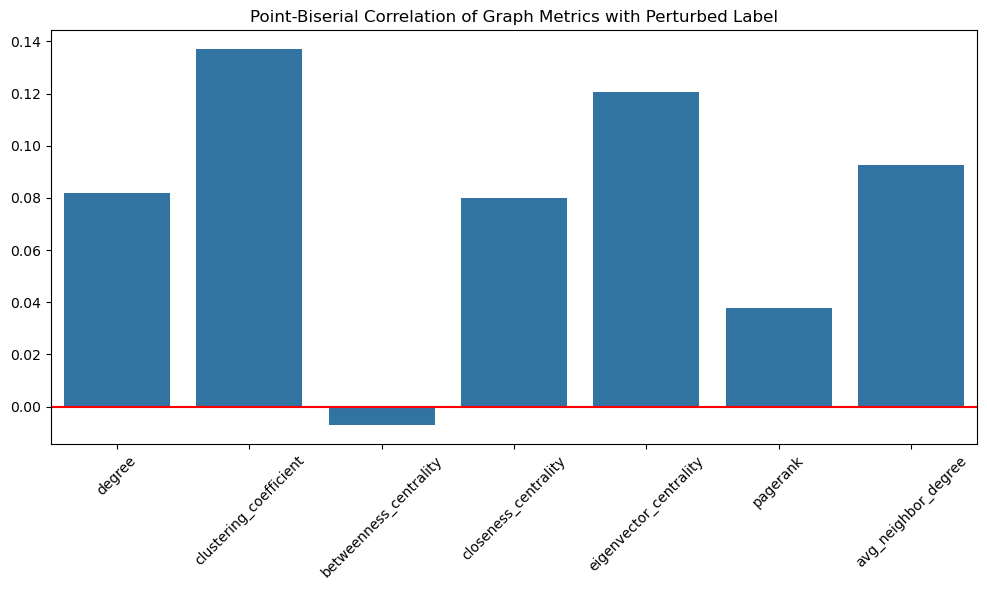

In [11]:
from scipy.stats import pointbiserialr

correlations = {}
for col in metrics_df.columns:
    correlations[col] = pointbiserialr(analysis_df['Perturbed'].astype(int), analysis_df[col])[0]

# Create a correlation plot
plt.figure(figsize=(10, 6))
sns.barplot(x=list(correlations.keys()), y=list(correlations.values()))
plt.title('Point-Biserial Correlation of Graph Metrics with Perturbed Label')
plt.xticks(rotation=45)
plt.axhline(y=0, color='r', linestyle='-')
plt.tight_layout()
plt.savefig('../figures/preprocessing/ppi_metrics_correlation.svg', dpi=400)
plt.show()


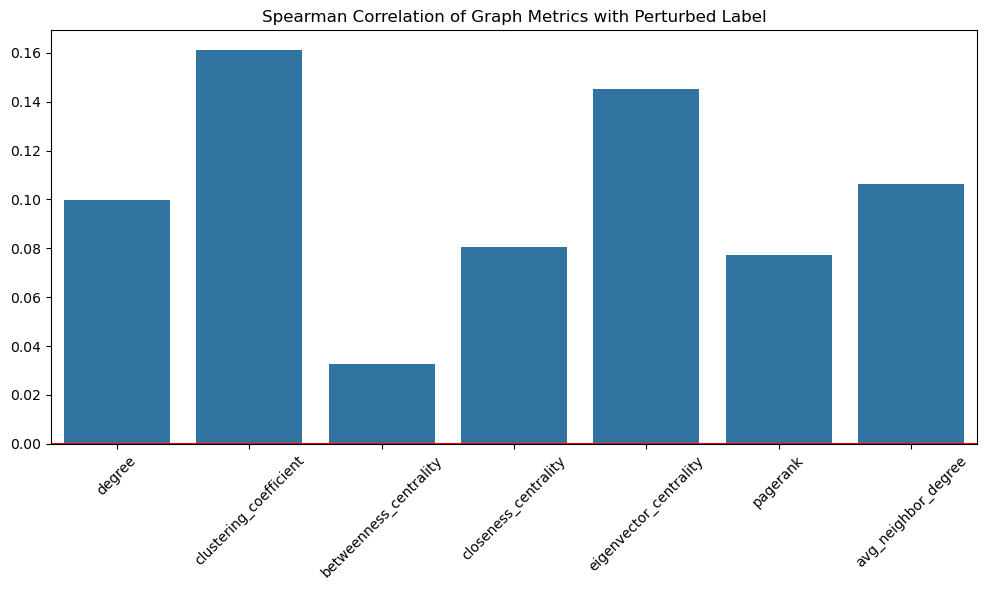

In [12]:
# Calculate correlations with the Perturbed label
correlations = {}
for col in metrics_df.columns:
    correlations[col] = spearmanr(analysis_df[col], analysis_df['Perturbed'].astype(int))[0]

# Create a correlation plot
plt.figure(figsize=(10, 6))
sns.barplot(x=list(correlations.keys()), y=list(correlations.values()))
plt.title('Spearman Correlation of Graph Metrics with Perturbed Label')
plt.xticks(rotation=45)
plt.axhline(y=0, color='r', linestyle='-')
plt.tight_layout()
plt.show()

In [ ]:
# Prepare features and target
X = analysis_df.drop('Perturbed', axis=1)
y = analysis_df['Perturbed']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a random forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance for Predicting Perturbed Label')
plt.tight_layout()
plt.show()

In [ ]:
# Compare distributions of metrics between perturbed and non-perturbed nodes
top_metrics = feature_importance['Feature'].iloc[:3].tolist()  # Top 3 important features

plt.figure(figsize=(15, 5))
for i, metric in enumerate(top_metrics):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x='Perturbed', y=metric, data=analysis_df.reset_index())
    plt.title(f'{metric} by Perturbed Status')

plt.tight_layout()
plt.show()

In [ ]:
# Check if perturbed nodes cluster together
communities = nx.community.greedy_modularity_communities(G)

# Analyze perturbed node distribution across communities
community_analysis = []
for i, community in enumerate(communities):
    community_nodes = set(community)
    perturbed_in_community = sum(1 for node in community_nodes if node in labels_df.index and labels_df.loc[node, 'Perturbed'])
    community_analysis.append({
        'community_id': i,
        'size': len(community),
        'perturbed_count': perturbed_in_community,
        'perturbed_ratio': perturbed_in_community / len(community)
    })

community_df = pd.DataFrame(community_analysis)
print(community_df.sort_values('perturbed_ratio', ascending=False))